In [1]:
import sys
import numpy as np
import ase 
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
from dpnegf.sktb.BuildHS import BuildHSreal
from dpnegf.sktb.StructData import StructBuild,BondListBuild
from dpnegf.sktb.SlaterKosterPara import  SlaterKosterInt
from dpnegf.sktb.base_hamiltonian import RotateHS
from dpnegf.Parameters import Paras
from dpnegf.nnet.Data import DataLoad
from dpnegf.sktb.StructData import EnvBuild
from dpnegf.nnet.NetWorks import *
from dpnegf.nnet.Model import Model


In [2]:
input_file='./TBmodel/hBN/train/input.json'
fp = open(input_file)
paras = Paras(file=fp)
#paras.sktbnegfparas()
paras.trainmode='restart'
paras.read_checkpoint = './TBmodel/hBN/train/checkpoint.pl'

In [3]:
dataload = DataLoad(paras)
#dataload.trainparas()
#dataload.traindata()
mdl = Model(paras)

# init BondListBuild calss.
# init StructBuild class.
# Atom type: N, ID : 1
# Atom type: B, ID : 2
# Reading SlaterKoster File......
# ./slakos/N-N.skf
# This file is a Homo-nuclear case!
# Reading SlaterKoster File......
# ./slakos/N-B.skf
# This is for Hetero-nuclear case!
# Reading SlaterKoster File......
# ./slakos/B-N.skf
# This is for Hetero-nuclear case!
# Reading SlaterKoster File......
# ./slakos/B-B.skf
# This file is a Homo-nuclear case!
# initial rotate H or S func.
# init StructBuild class.
# allocate nn models


In [4]:
asestr = ase.io.read('./TBmodel/hBN/check/hBN.vasp')

In [5]:
mdl.loadmodel()

# NN: 4  independent hoppings
## ss: [0]    sp: [1]    ps: [1]    pp: [2, 3]    
# NB: 5  independent hoppings
## ss: [0]    sp: [1]    ps: [2]    pp: [3, 4]    
# BN: 5  independent hoppings
## ss: [0]    sp: [2]    ps: [1]    pp: [3, 4]    
# BB: 4  independent hoppings
## ss: [0]    sp: [1]    ps: [1]    pp: [2, 3]    
# N: {'s': [0], 'p': [1]}  independent onsite Es
## s: [0]    p: [1]    
# B: {'s': [0], 'p': [1]}  independent onsite Es
## s: [0]    p: [1]    


In [6]:
mdl.structinput(asestr)
mdl.nnhoppings()
mdl.SKhoppings()
 

In [7]:
snapase = asestr
#snapase = structase
lat = snapase.cell.get_bravais_lattice()
print(lat.description())
#lat.plot_bz(show=True)
special_kp = lat.get_special_points()
#spmap['M'] = np.array([0.5,0.5,1])
#kpath=snapase.cell.bandpath('XGX', npoints=120)
kpath=snapase.cell.bandpath('GMKG', npoints=120)
xlist, high_sym_kpoints, labels = kpath.get_linear_kpoint_axis()
klist = kpath.kpts

HEX(a=2.504, c=30)
  Variant name: HEX
  Special point names: GMKALH
  Default path: GMKGALHA,LM,KH

  Special point coordinates:
    G   0.0000  0.0000  0.0000
    M   0.5000  0.0000  0.0000
    K   0.3333  0.3333  0.0000
    A   0.0000  0.0000  0.5000
    L   0.5000  0.0000  0.5000
    H   0.3333  0.3333  0.5000



In [8]:
# This is for sk paras only.
mdl.HSmat(hoppings = mdl.skhoppings, overlaps = mdl.skoverlaps, 
              onsiteEs = mdl.onsiteEs, onsiteSs = mdl.onsiteSs)
# This is for TB with NN corrections.              
mdl.SKcorrection()
mdl.HSmat(hoppings = mdl.hoppings_corr, overlaps = mdl.overlaps_corr , 
              onsiteEs = mdl.onsiteEs_corr, onsiteSs = mdl.onsiteSs_corr)

In [9]:
eigks = mdl.Eigenvalues(kpoints = klist)
eigksnp =  eigks.detach().numpy()

In [10]:
nk = eigksnp.shape[0]
ValElec = np.asarray(mdl.bondbuild.ProjValElec)
nume = np.sum(ValElec[mdl.bondbuild.TypeID])
numek = nume * nk//2
sorteigs =  np.sort(np.reshape(eigksnp,[-1]))
EF=(sorteigs[numek] + sorteigs[numek-1])/2

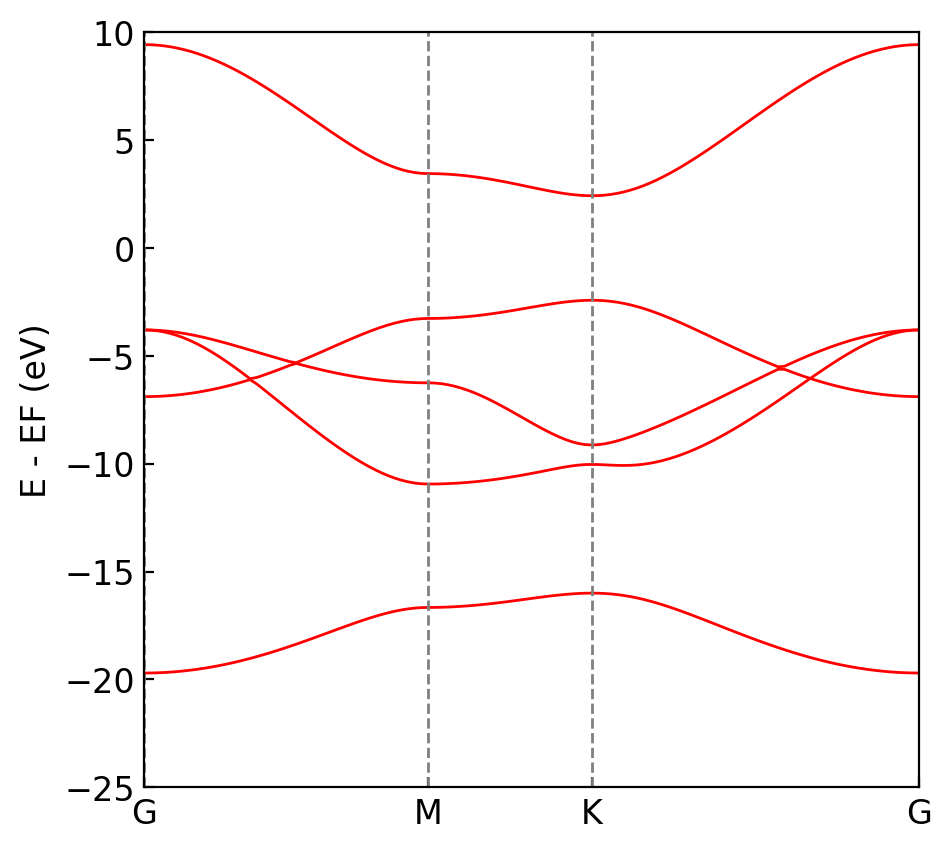

In [11]:
plt.figure(figsize=(5,5),dpi=200)
for i in range(eigksnp.shape[1]):
    plt.plot(xlist, eigksnp[:,i] - EF,'r-',lw=1)
for ii in high_sym_kpoints:
    plt.axvline(ii,color='gray',lw=1,ls='--')
plt.tick_params(direction='in')
plt.ylim(-25,10)
plt.xlim(xlist.min(),xlist.max())
plt.ylabel('E - EF (eV)',fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(high_sym_kpoints,labels,fontsize=12)
plt.show()

In [14]:
mdl.envbuild.ProjEnv

array([[[0, 0, -1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 1, 1, 0],
        [0, 0, -1, -1, 0],
        [0, 0, 0, -1, 0],
        [1, 1, -1, 0, 0],
        [1, 1, -1, 1, 0],
        [1, 1, 0, 1, 0],
        [1, 1, 1, 1, 0],
        [1, 1, 0, 0, 0],
        [1, 1, -1, -1, 0]],

       [[0, 0, 1, 1, 0],
        [0, 0, 1, -1, 0],
        [0, 0, 0, -1, 0],
        [0, 0, -1, -1, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [1, 1, 1, 1, 0],
        [1, 1, 0, -1, 0],
        [1, 1, -1, -1, 0],
        [1, 1, -1, 0, 0],
        [1, 1, 1, 0, 0],
        [1, 1, 0, 1, 0]]], dtype=object)